In [6]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})


import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
allensdk.__version__
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

In [175]:
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

In [7]:
def plot_tuning_curve(tuning_curve, cell_specimen_id):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(tuning_curve.index.values, tuning_curve.mean_response.values, 'or', linestyle='--')
    ax.set_title('cell_specimen_id: '+str(cell_specimen_id)+'\nImage selectivity')
    ax.set_xticklabels(tuning_curve.index.values, rotation=90)
    ax.set_ylabel('dF/F')

def crossValidateLinearModel(X, y , n_split = 5, shuffle = False, shuffle_seed = None):
    '''
    Cross validate a linear model using KFold cross validation

    Parameters
    ----------
    X : np.array
        The input data to fit
    y : np.array
        The output data to fit
    n_split : int
        The number of splits to use
    shuffle : bool
        Whether or not to shuffle the data
    shuffle_seed : int
        The seed to use for shuffling the data

    Returns
    -------
    Mean Score: float
        The average cross validation score
    Model List: list    
        The models fit to each fold of the data
    Test score: np.array    
        The cross validation scores for testing data each fold
    Train score: np.array
        The cross validation scores for testing data each fold
    '''

    if len(X.shape)==1:
        X = X.copy().reshape(-1,1)
    # Initialize KFold object
    folderizer = KFold(n_splits=n_split,shuffle=shuffle,random_state=shuffle_seed)
    # Create an array to save the results
    self_score = np.empty(n_split)
    cross_score = np.empty(n_split)
    models = [None]*n_split
    # Loop through the folds, fit the model, and save the results
    for ii, (train_index, test_index) in enumerate(folderizer.split(X,y)):
        models[ii] = LinearRegression(fit_intercept=False).fit(X[train_index,:], y[train_index])
        self_score[ii] = models[ii].score(X[train_index,:], y[train_index])
        cross_score[ii] = models[ii].score(X[test_index,:], y[test_index])
        
    return np.mean(cross_score),models,cross_score,self_score


# rewrite but use fold strategy approriate for time series data
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
def crossValidateLinearModelTimeSeries(X, y, n_split=5):
    '''
    Cross validate a linear model using TimeSeriesSplit cross validation.

    Parameters
    ----------
    X : np.array
        The input data to fit
    y : np.array
        The output data to fit
    n_split : int
        The number of splits for cross-validation

    Returns
    -------
    Mean Score : float
        The average cross-validation score
    Model List : list    
        The models fit to each fold of the data
    Test score : np.array    
        The cross-validation scores for testing data each fold
    Train score : np.array
        The cross-validation scores for training data each fold
    '''

    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    # Initialize TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=n_split)
    
    # Create arrays to save the results
    test_scores = np.empty(n_split)
    train_scores = np.empty(n_split)
    models = [None] * n_split
    
    # Loop through the folds, fit the model, and save the results
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and fit the linear model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict on both training and testing data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # # Calculate the mean squared error for both training and testing data
        # train_score = mean_squared_error(y_train, y_train_pred)
        # test_score = mean_squared_error(y_test, y_test_pred)
        
        train_score = r2_score(y_train, y_train_pred)
        test_score = r2_score(y_test, y_test_pred)
        
        # Save the scores and model
        train_scores[i] = train_score
        test_scores[i] = test_score
        models[i] = model
    
    # Calculate the mean cross-validation score
    mean_score = np.mean(test_scores)
    
    return mean_score, models, test_scores, train_scores


Matt #1 - Decoding context (active / passive) with VBO - consider extending to VBN and/or decoding familiar images in familiar sessions vs in novel sessions (another context question)
Matt #2 - Natural movie one coding / decoding across sessions for VCO + VBO (representational drift?)

/home/matt.davis/code/AllenSDK/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
/data/learning/mattd/miniconda3/envs/dev/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], 

Mice: 24
['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt']
cre_line           mouse_id
Slc17a7-IRES2-Cre  453911      11
                   451787       8
                   547486       8
                   456915       6
                   479839       6
                   484627       6
                   485152       6
                   541329       6
                   547266       6
Sst-IRES-Cre       482853       9
                   457841       8
                   440631       7
                   448366       6
                   544965       6
                   546605       5
Vip-IRES-Cre       435431       9
                   453990       9
                   438912       6
                   453988       6
                   453989       6
                   453991       6
                   523922       6
                   449653       5
                   528

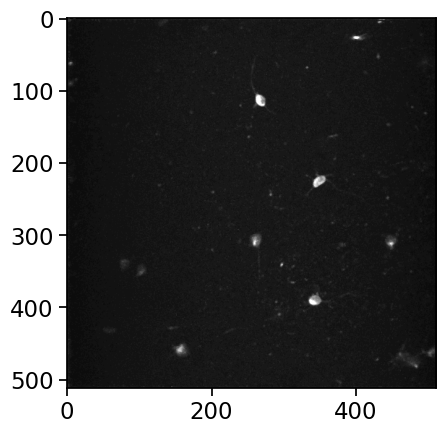

In [8]:
output_dir = r'/swdb2024_data_cache'
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)

behavior_session_table = cache.get_behavior_session_table()  
ophys_session_table = cache.get_ophys_session_table()   
ophys_experiment_table = cache.get_ophys_experiment_table()    
ophys_cells_table = cache.get_ophys_cells_table()


project_code = 'VisualBehaviorMultiscope'
multiscope_sessions = ophys_session_table[ophys_session_table.project_code==project_code]

print(f"Mice: {len(multiscope_sessions.mouse_id.unique())}")
print(multiscope_sessions.full_genotype.unique())
print(multiscope_sessions.groupby("cre_line").mouse_id.value_counts())

# mouse + sessions
mouse_id = '546605' # SST
sessions = ophys_session_table[(ophys_session_table.mouse_id==mouse_id) & 
                                (ophys_session_table.session_type=='OPHYS_1_images_A')]

# experiment
ophys_experiment_id = 1080945462
dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)

plt.imshow(dataset.max_projection, cmap='gray')

# stim presentations
stimulus_presentations = dataset.stimulus_presentations.copy()
stimulus_presentations = stimulus_presentations[stimulus_presentations.stimulus_block_name=='change_detection_behavior']
print(stimulus_presentations.stimulus_block_name.unique())
print(stimulus_presentations.image_name.unique())

# pick cell
cell_specimen_id = 1120091421

100%|██████████| 5/5 [00:00<00:00, 24.40it/s]
/tmp/ipykernel_7300/283849776.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tuning_curve = cell_df.groupby(['image_name']).mean()[['mean_response']]
/tmp/ipykernel_7300/2302397451.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tuning_curve.index.values, rotation=90)


,mean_response
image_name,
im061,-0.029052
im062,-0.045840
im063,0.203203
im065,0.070129
im066,0.458043
im069,-0.009469
im077,0.039101
im085,0.164133


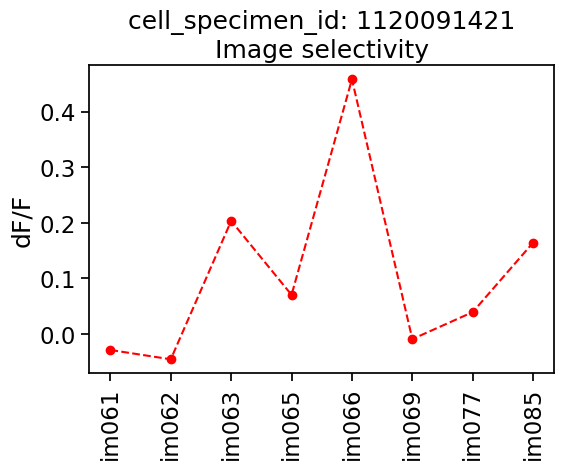

In [9]:

stimulus_presentations = stimulus_presentations[stimulus_presentations.stimulus_block_name=='change_detection_behavior']

stimulus_response_df = data_formatting.get_stimulus_response_df(dataset, data_type='dff', event_type='changes',
                                                            time_window=[-1, 1], response_window_duration=0.5,
                                                            interpolate=True, output_sampling_rate=30)

stimulus_response_df = stimulus_response_df.merge(stimulus_presentations, on='stimulus_presentations_id')

cell_df = stimulus_response_df[stimulus_response_df.cell_specimen_id==cell_specimen_id]

tuning_curve = cell_df.groupby(['image_name']).mean()[['mean_response']]
plot_tuning_curve(tuning_curve, cell_specimen_id)
tuning_curve

In [33]:
y = cell_df.mean_response.values

#X_pupil = cell_df.mean_pupil_width.values
#X_running = cell_df.mean_running_speed.values


# X for stim
img_index = cell_df.image_index.values
X = np.zeros((len(img_index),8))
for ii in range(len(img_index)):
    X[ii,img_index[ii]]  = 1
X_stim = X.copy()


In [37]:
seed = 5
x_stim_score,models,_,_  = crossValidateLinearModel(X_stim, y, shuffle = True, shuffle_seed=seed)
print(x_stim_score)

0.20094699101545768


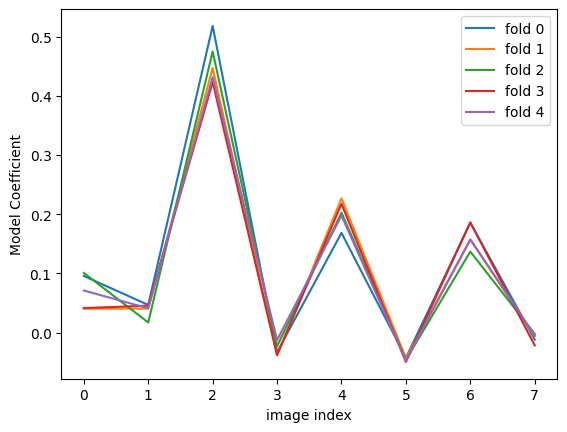

In [38]:
fig,ax = plt.subplots()

# Loop over folds and plot the coefficients
for ii in range(len(models)):
    ax.plot(models[ii].coef_, label = f'fold {ii}')
# Label the axes
ax.set_xlabel('image index')
ax.set_ylabel('Model Coefficient')
ax.legend()